# Statistical analysis and visualization of the results from the three methods

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import csv
import seaborn as sns

import statistics

from scipy.stats import wilcoxon
import sklearn
from sklearn.metrics import mean_squared_error

## Initialize some paths and variables

In [2]:
path_parent = os.path.dirname(os.getcwd())
rootdir = os.path.join(path_parent, "results")
subdirs = ["orcnn_with_dlregression", "orcnn_with_filtering", "mrcnn_with_filtering"]
labels = ["ORCNN + regression", "ORCNN + filtering", "MRCNN + filtering"]
colors = ["blue", "orange", "green"]

image_num = 487
font_size = 11
digit_size = 9

## Store the results in one array

In [3]:
data_combined = np.zeros((image_num*len(subdirs), 10), dtype = object)
counter = 0

for i in range(len(subdirs)):
    subdir = subdirs[i]
    label = labels[i]
    readdir = os.path.join(rootdir, subdir)
    csvfile = "broccoli_diameter_" + subdir + ".csv"

    readfile = os.path.join(readdir, csvfile)

    with open(readfile, 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        next(csv_reader, None)
        for row in csv_reader:
            img_name = row[0]
            amodal_iou = row[1]
            real_diameter = row[2]
            estimated_diameter = row[3]
            diff = row[4]
            ocr = row[5]
            analysis_time = row[6]

            data_combined[counter, 0] = img_name
            data_combined[counter, 1] = float(amodal_iou)
            data_combined[counter, 2] = float(real_diameter)
            data_combined[counter, 3] = float(estimated_diameter)
            data_combined[counter, 4] = float(diff)
            data_combined[counter, 5] = abs(float(diff))
            data_combined[counter, 6] = round(statistics.ceil_to_decimal(float(ocr)), 1)
            data_combined[counter, 7] = analysis_time
            data_combined[counter, 8] = i
            data_combined[counter, 9] = label
            counter = counter+1

## Initialize a dataframe, which will store the results

In [4]:
df = pd.DataFrame(data=data_combined, columns=["name", "iou", "real_d", "pred_d", "diff", "abs_diff", "ocr", "time", "method_id", "method"])
df["abs_diff"] = df["abs_diff"].astype(float)
avg_diff = df.groupby(["method"])["abs_diff"].mean()
max_diff = df.groupby(["method"])["abs_diff"].max()

df["diff"] = df["diff"].astype(float)
diffs = df.groupby(["method"])["diff"].apply(list)
real_diameters = df.groupby(["method"])["real_d"].apply(list)
pred_diameters = df.groupby(["method"])["pred_d"].apply(list)

df["iou"] = df["iou"].astype(float)
df["time"] = df["time"].astype(float)
df["method_id"] = df["method_id"].astype(int)

## Do some summary statistics and plot a histogram

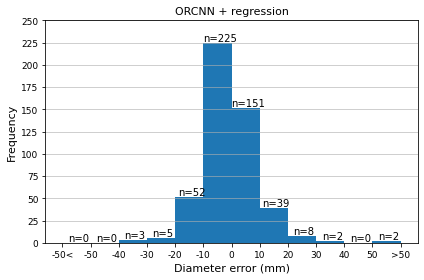

AVG absolute diameter error: 6.8 mm
MAX absolute diameter error: 52.0 mm
RMSE of diameter: 9.5



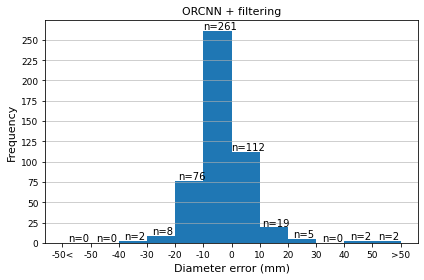

AVG absolute diameter error: 7.3 mm
MAX absolute diameter error: 80.2 mm
RMSE of diameter: 10.5



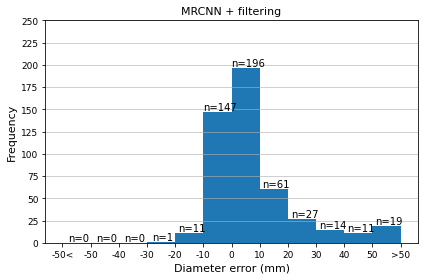

AVG absolute diameter error: 10.8 mm
MAX absolute diameter error: 123.1 mm
RMSE of diameter: 18.8



In [5]:
for i in range(len(labels)):
    label = labels[i]
    statistics.histogram_error_fixed_scale(np.asarray(diffs[label]), label, -60, 60, 120, 12, digit_size, font_size)

    print("AVG absolute diameter error: {0:.1f} mm".format(avg_diff[label]))
    print("MAX absolute diameter error: {0:.1f} mm".format(max_diff[label]))

    rmse = mean_squared_error(real_diameters[label], pred_diameters[label], squared=False)
    print("RMSE of diameter: {0:.1f}".format(rmse))
    print("")

## Plot a combined kernel density estimate

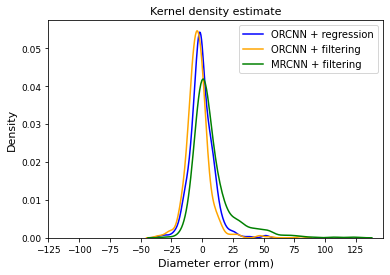

In [6]:
for i in range(len(labels)):
    label = labels[i]
    color = colors[i]
    sns.kdeplot(diffs[label] , color=color, label=label)
    
plt.xticks(range(-125, 150, 25), fontsize=digit_size)
plt.yticks(fontsize=digit_size)
plt.xlabel("Diameter error (mm)", fontsize=font_size)
plt.ylabel("Density", fontsize=font_size)
plt.title("Kernel density estimate", fontsize=font_size)
plt.legend()
plt.show()

## Store the unique occlusion rates as 10 bins

In [7]:
unique_ocrs = list(set(df["ocr"]))
unique_ocrs.sort()
ocr_counts = np.zeros(len(unique_ocrs)).astype(np.uint8)

x_ticks_list = []

for j in range(len(unique_ocrs)):
    unique_ocr = unique_ocrs[j]
    ocr_count = int(len(np.where(df["ocr"] == unique_ocr)[0])/3)
    ocr_counts[j] = ocr_count

    x_ticks_list.append('{0:.1f}-{1:.1f}'.format(unique_ocr-0.1, unique_ocr))

## Make a combined line-plot of the amodal IoU as a function of the occlusion rate

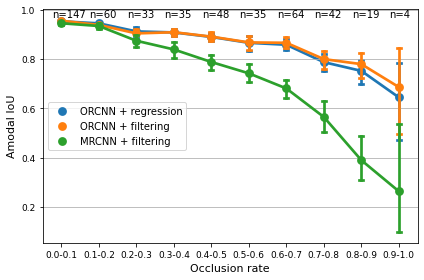

In [8]:
g = sns.pointplot(x="ocr", y="iou", hue="method", data=df, capsize=.1)
g.get_legend().remove()
plt.legend(loc='center left')

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.25, 0.97))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.xlabel("Occlusion rate", fontsize=font_size)

plt.yticks(fontsize=digit_size)
plt.ylabel("Amodal IoU", fontsize=11)
plt.grid(which='major', axis='y', linestyle='-')

plt.tight_layout()
plt.show()

## Make a combined line-plot of the diameter error as a function of the occlusion rate

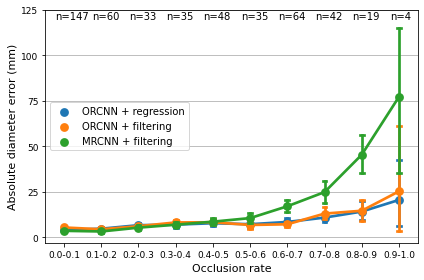

In [9]:
bin_step = 25
max_val = statistics.ceil_to_25(np.max(df["abs_diff"]))

g = sns.pointplot(x="ocr", y="abs_diff", hue="method", data=df, capsize=.1)
g.get_legend().remove()
plt.legend(loc='center left')

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.25, 120))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.xlabel("Occlusion rate", fontsize=font_size)

plt.yticks(range(0, int(max_val) + bin_step, bin_step), fontsize=digit_size)
plt.ylabel("Absolute diameter error (mm)", fontsize=11)
plt.grid(which='major', axis='y', linestyle='-')

plt.tight_layout()
plt.show()

## Make a dual y-axis line-plot of the diameter error and the amodal IoU as a function of the occlusion rate

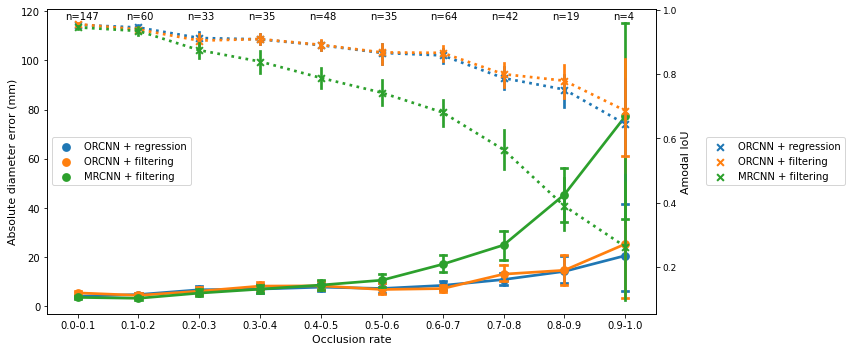

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 5))
g1 = sns.pointplot(x="ocr", y="abs_diff", hue="method", data=df, ax=ax1, capsize=.1)
g1.get_legend().remove()
ax1.set_xlabel("Occlusion rate", fontsize=font_size)
ax1.set_ylabel("Absolute diameter error (mm)", fontsize=font_size)
ax1.legend(loc='center left')

ax2 = ax1.twinx()
g2 = sns.pointplot(x="ocr", y="iou", hue="method", data=df, ax=ax2, markers=["x", "x", "x"], linestyles=[":", ":", ":"])
g2.get_legend().remove()
ax2.set_ylabel("Amodal IoU", fontsize=font_size)
ax2.legend(loc='center left', bbox_to_anchor=(1.075, 0.5))

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.2, 0.97))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.yticks(fontsize=digit_size)

plt.tight_layout()
plt.show()

## Boxplot with the inference times for all methods

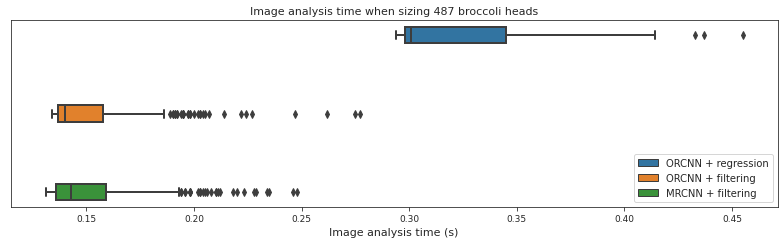

In [11]:
sns.set_style("ticks")
f, ax = plt.subplots(figsize=(11, 3.5))

ax = sns.boxplot(x="time", y="method_id", hue="method", orient="h", linewidth=2, data=df)
ax.set_ylabel('')
plt.legend(loc='lower right')

plt.xlabel('Image analysis time (s)', fontsize=font_size)
plt.xticks(fontsize=digit_size)
plt.yticks([])

plt.title("Image analysis time when sizing {0:.0f} broccoli heads".format(image_num), fontsize=font_size)

plt.tight_layout()
plt.show()

## Wilcoxon Signed-Rank Test of amodal IoU for each occlusion rate

In [12]:
## thanks to: https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
iou = df.groupby(["name", "ocr", "method"])["iou"].apply(list)
ocr = df.groupby(["name"])["ocr"].apply(list)

ids1 = np.arange(0, len(iou), 3)
ids2 = np.arange(1, len(iou), 3)
ids3 = np.arange(2, len(iou), 3)

iou_mf = np.zeros(len(ids1)).astype(np.float32)
iou_of = np.zeros(len(ids2)).astype(np.float32)
iou_or = np.zeros(len(ids3)).astype(np.float32)

ocrs = np.zeros(len(ids1)).astype(np.float32)

for i in range(len(iou)):
    if i in ids1:
        idx = int(i/3)
        iou_mf[idx] = iou[i][0]
        ocrs[idx] = ocr[idx][0]
    if i in ids2:
        idx = int((i-1)/3)
        iou_of[idx] = iou[i][0]
    if i in ids3:
        idx = int((i-2)/3)
        iou_or[idx] = iou[i][0]
        
alpha = 0.05
print("{:<28} {:<41} {:<40}".format('', 'AVG (STD) of amodal IoU', 'P-value Wilcoxon Signed-Rank Test'))
print("{:<20} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".format('Occlusion rate', 'MF', 'OF', 'OR', 'MF-OF', 'MF-OR', 'OF-OR'))

for j in range(len(unique_ocrs)):
    unique_ocr = unique_ocrs[j]    
    idxs = np.where(ocrs == unique_ocr)[0]
    
    m_f = []
    o_f = []
    o_r = []
    
    for k in range(len(idxs)):
        idx = idxs[k]
        m_f.append(iou_mf[idx])
        o_f.append(iou_of[idx])
        o_r.append(iou_or[idx])
        
    stat, p_mf_of = wilcoxon(m_f, o_f)
    stat, p_mf_or = wilcoxon(m_f, o_r)
    stat, p_of_or = wilcoxon(o_f, o_r)
    
    ocr_string = '{0:.1f}-{1:.1f}'.format(unique_ocr-0.1, unique_ocr)
    avgstd_mf = '{0:.2f} ({1:.2f})'.format(np.average(m_f), np.std(m_f))
    avgstd_of = '{0:.2f} ({1:.2f})'.format(np.average(o_f), np.std(o_f))
    avgstd_or = '{0:.2f} ({1:.2f})'.format(np.average(o_r), np.std(o_r))

    if j != (len(unique_ocrs)-1):
        p_mf_of = '{0:.2f}'.format(p_mf_of)
        p_mf_or = '{0:.2f}'.format(p_mf_or)
        p_of_or = '{0:.2f}'.format(p_of_or)
    else:
        p_mf_of = '*'
        p_mf_or = '*'
        p_of_or = '*'

    print("{:<20} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".format(ocr_string, avgstd_mf, avgstd_of, avgstd_or, p_mf_of, p_mf_or, p_of_or))
    
print("")
print("Explanation:")
print("MF : Mask R-CNN + Filtering")
print("OF : ORCNN + Filtering")
print("OR : ORCNN + Regression")
print("")
print("MF-OF : rank comparison between Mask R-CNN + Filtering and ORCNN + Filtering")
print("MF-OR : rank comparison between Mask R-CNN + Filtering and ORCNN + Regression")
print("OF-OR : rank comparison between ORCNN + Filtering and ORCNN + Regression")
print("")
print("* : sample size too small for normal approximation")
print("")
print("The P-values lower than 0.05 indicate that the tested distributions are significantly different")

                             AVG (STD) of amodal IoU                   P-value Wilcoxon Signed-Rank Test       
Occlusion rate       MF              OF              OR              MF-OF           MF-OR           OF-OR          
0.0-0.1              0.95 (0.03)     0.96 (0.03)     0.95 (0.02)     0.00            0.00            0.23           
0.1-0.2              0.93 (0.05)     0.94 (0.03)     0.95 (0.03)     0.65            0.04            0.03           
0.2-0.3              0.87 (0.07)     0.90 (0.07)     0.91 (0.06)     0.03            0.00            0.09           
0.3-0.4              0.84 (0.10)     0.91 (0.05)     0.91 (0.05)     0.00            0.00            0.93           
0.4-0.5              0.79 (0.11)     0.89 (0.06)     0.89 (0.05)     0.00            0.00            0.65           
0.5-0.6              0.74 (0.12)     0.87 (0.10)     0.87 (0.09)     0.00            0.00            0.59           
0.6-0.7              0.68 (0.16)     0.87 (0.09)     0.86 (0.09)     

## Wilcoxon Signed-Rank Test of diameter error for each occlusion rate

In [13]:
## thanks to: https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
abs_diff = df.groupby(["name", "ocr", "method"])["abs_diff"].apply(list)
ocr = df.groupby(["name"])["ocr"].apply(list)

ids1 = np.arange(0, len(abs_diff), 3)
ids2 = np.arange(1, len(abs_diff), 3)
ids3 = np.arange(2, len(abs_diff), 3)

abs_diff_mf = np.zeros(len(ids1)).astype(np.float32)
abs_diff_of = np.zeros(len(ids2)).astype(np.float32)
abs_diff_or = np.zeros(len(ids3)).astype(np.float32)

ocrs = np.zeros(len(ids1)).astype(np.float32)

for i in range(len(abs_diff)):
    if i in ids1:
        idx = int(i/3)
        abs_diff_mf[idx] = abs_diff[i][0]
        ocrs[idx] = ocr[idx][0]
    if i in ids2:
        idx = int((i-1)/3)
        abs_diff_of[idx] = abs_diff[i][0]
    if i in ids3:
        idx = int((i-2)/3)
        abs_diff_or[idx] = abs_diff[i][0]
        
        
alpha = 0.05
print("{:<20} {:<46} {:<40}".format('', ' AVG (STD) of absolute diameter error (mm)', '   P-value Wilcoxon Signed-Rank Test'))
print("{:<20} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".format('Occlusion rate', 'MF', 'OF', 'OR', 'MF-OF', 'MF-OR', 'OF-OR'))

for j in range(len(unique_ocrs)):
    unique_ocr = unique_ocrs[j]    
    idxs = np.where(ocrs == unique_ocr)[0]
    
    m_f = []
    o_f = []
    o_r = []
    
    for k in range(len(idxs)):
        idx = idxs[k]
        m_f.append(abs_diff_mf[idx])
        o_f.append(abs_diff_of[idx])
        o_r.append(abs_diff_or[idx])
        
    stat, p_mf_of = wilcoxon(m_f, o_f)
    stat, p_mf_or = wilcoxon(m_f, o_r)
    stat, p_of_or = wilcoxon(o_f, o_r)
    
    ocr_string = '{0:.1f}-{1:.1f}'.format(unique_ocr-0.1, unique_ocr)
    avgstd_mf = '{0:.2f} ({1:.2f})'.format(np.average(m_f), np.std(m_f))
    avgstd_of = '{0:.2f} ({1:.2f})'.format(np.average(o_f), np.std(o_f))
    avgstd_or = '{0:.2f} ({1:.2f})'.format(np.average(o_r), np.std(o_r))

    if j != (len(unique_ocrs)-1):
        p_mf_of = '{0:.2f}'.format(p_mf_of)
        p_mf_or = '{0:.2f}'.format(p_mf_or)
        p_of_or = '{0:.2f}'.format(p_of_or)
    else:
        p_mf_of = '*'
        p_mf_or = '*'
        p_of_or = '*'

    print("{:<20} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".format(ocr_string, avgstd_mf, avgstd_of, avgstd_or, p_mf_of, p_mf_or, p_of_or))
    
print("")
print("Explanation:")
print("MF : Mask R-CNN + Filtering")
print("OF : ORCNN + Filtering")
print("OR : ORCNN + Regression")
print("")
print("MF-OF : rank comparison between Mask R-CNN + Filtering and ORCNN + Filtering")
print("MF-OR : rank comparison between Mask R-CNN + Filtering and ORCNN + Regression")
print("OF-OR : rank comparison between ORCNN + Filtering and ORCNN + Regression")
print("")
print("* : sample size too small for normal approximation")
print("")
print("The P-values lower than 0.05 indicate that the tested distributions are significantly different")

                      AVG (STD) of absolute diameter error (mm)        P-value Wilcoxon Signed-Rank Test    
Occlusion rate       MF              OF              OR              MF-OF           MF-OR           OF-OR          
0.0-0.1              3.60 (3.08)     5.43 (4.17)     4.07 (3.44)     0.00            0.06            0.00           
0.1-0.2              3.24 (2.55)     4.43 (3.93)     4.76 (3.09)     0.05            0.00            0.42           
0.2-0.3              5.35 (4.11)     6.13 (4.48)     6.69 (3.87)     0.52            0.28            0.45           
0.3-0.4              6.95 (4.78)     8.20 (4.88)     6.99 (5.80)     0.28            0.94            0.25           
0.4-0.5              8.62 (6.98)     8.30 (5.82)     7.78 (5.84)     1.00            0.59            0.35           
0.5-0.6              10.59 (7.82)    6.82 (6.85)     7.22 (6.14)     0.07            0.08            0.79           
0.6-0.7              17.09 (13.70)   7.19 (5.95)     8.47 (7.18)     0.0